<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1577]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

#### Load the file and overview the data

In [1578]:
# Load the data
house = pd.read_csv('./housing.csv')

In [1579]:
# A:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1580]:
house.shape

(1460, 81)

In [1581]:
house.rename(columns={'1stFlrSF':'FirstFlrSF',
                      '2ndFlrSF':'SecondFlrSF', 
                      '3SsnPorch': 'ThreeSsnPorch'}, inplace=True)

In [1582]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'Paved

In [1583]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

#### Filtering only residential houses or zone only

In [1584]:
house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [1585]:
Residential_house = house[house['MSZoning'].isin(['RH','RL','RP','RM','FV'])]

In [1586]:
Residential_house['MSZoning'].value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [1587]:
Residential_house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1588]:
Residential_house.shape

(1450, 81)

#### EDA - Cleaning Null

In [1589]:
# Checking the null counts and percentage
check_null = list(zip(Residential_house.columns,
                      Residential_house.isnull().sum(),
                      np.round(Residential_house.isnull().sum()/Residential_house.shape[0],3)))
[x for x in check_null if x[1] !=0]

[('LotFrontage', 259, 0.179),
 ('Alley', 1361, 0.939),
 ('MasVnrType', 8, 0.006),
 ('MasVnrArea', 8, 0.006),
 ('BsmtQual', 37, 0.026),
 ('BsmtCond', 37, 0.026),
 ('BsmtExposure', 38, 0.026),
 ('BsmtFinType1', 37, 0.026),
 ('BsmtFinType2', 38, 0.026),
 ('Electrical', 1, 0.001),
 ('FireplaceQu', 681, 0.47),
 ('GarageType', 79, 0.054),
 ('GarageYrBlt', 79, 0.054),
 ('GarageFinish', 79, 0.054),
 ('GarageQual', 79, 0.054),
 ('GarageCond', 79, 0.054),
 ('PoolQC', 1443, 0.995),
 ('Fence', 1172, 0.808),
 ('MiscFeature', 1398, 0.964)]

##### Handling NAN for 'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature' columns

In [1590]:
def fillna_func(column,replace_word):
    #print(Residential_house[column].value_counts(dropna=False))
    Residential_house[column].fillna(replace_word, axis=0, inplace=True)
    #print(Residential_house[column].value_counts(dropna=False))

In [1591]:
# Replace nan value with NA for Alley column
fillna_func('Alley','NA')

/Users/nandar/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [1592]:
Columns_NA = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
              'BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual',
              'GarageCond','PoolQC','Fence','MiscFeature']

for x in Columns_NA:
    fillna_func(x,'NA')

In [1593]:
# Replace nan value with None for MasVnrType column
Columns_None = ['MasVnrType']
for x in Columns_None:
    fillna_func(x,'None')

##### <b> Handling NAN for Electrical column </b>

In [1594]:
Residential_house['Electrical'].value_counts(dropna=False)

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

In [1595]:
Residential_house[Residential_house['Electrical'].isnull()==True].index

Int64Index([1379], dtype='int64')

In [1596]:
# Drop the nan value from Electrical column since the ratio is 0.001
Residential_house.drop(Residential_house[Residential_house['Electrical'].isnull()==True].index,
                       axis=0, inplace=True)

/Users/nandar/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


##### <B>Replaceing NAN value with Mean values</b>

In [1597]:
def fillmean_func(column):
    Residential_house[column].fillna(np.mean(Residential_house[column]), 
                                     axis=0, inplace=True)

In [1598]:
Columns_Mean = ['LotFrontage','MasVnrArea','GarageYrBlt']

for x in Columns_Mean:
    fillmean_func(x)

In [1599]:
# Checking again to confirm there is no null anymore
check_null = list(zip(Residential_house.columns,
                      Residential_house.isnull().sum(),
                      np.round(Residential_house.isnull().sum()/Residential_house.shape[0],3)))
[x for x in check_null if x[1] !=0]

[]

In [1600]:
Residential_house['YearBuilt'].value_counts()

2006    66
2005    64
2004    54
2007    49
2003    45
1976    33
1977    32
1959    26
1920    26
1999    25
1998    25
1958    24
1965    24
1970    24
1954    24
2000    24
2002    23
2008    23
1972    23
1971    22
1968    22
1957    20
2001    20
1950    20
1994    19
1962    19
1966    18
1940    18
2009    18
1995    18
        ..
1935     5
1880     4
1938     4
1929     4
1983     4
1932     4
1952     4
1919     3
1934     3
1927     3
1989     3
1987     3
1912     3
1942     2
1908     2
1885     2
1890     2
1892     2
1875     1
1882     1
1893     1
2010     1
1898     1
1904     1
1905     1
1906     1
1911     1
1913     1
1917     1
1872     1
Name: YearBuilt, Length: 112, dtype: int64

In [1601]:
Residential_house['YrSold']-Residential_house['YearBuilt']

0        5
1       31
2        7
3       91
4        8
5       16
6        3
7       36
8       77
9       69
10      43
11       1
12      46
13       1
14      48
15      78
16      40
17      39
18       4
19      51
20       1
21      77
22       6
23      31
24      42
25       2
26      59
27       3
28      49
29      81
        ..
1430     1
1431    33
1432    80
1433     8
1434    29
1435    46
1436    36
1437     0
1438    53
1439    28
1440    86
1441     4
1442     1
1443    93
1444     3
1445    41
1446    48
1447    12
1448    97
1449    36
1450    35
1451     1
1452     1
1453     0
1454     5
1455     8
1456    32
1457    69
1458    60
1459    43
Length: 1449, dtype: int64

/Users/nandar/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


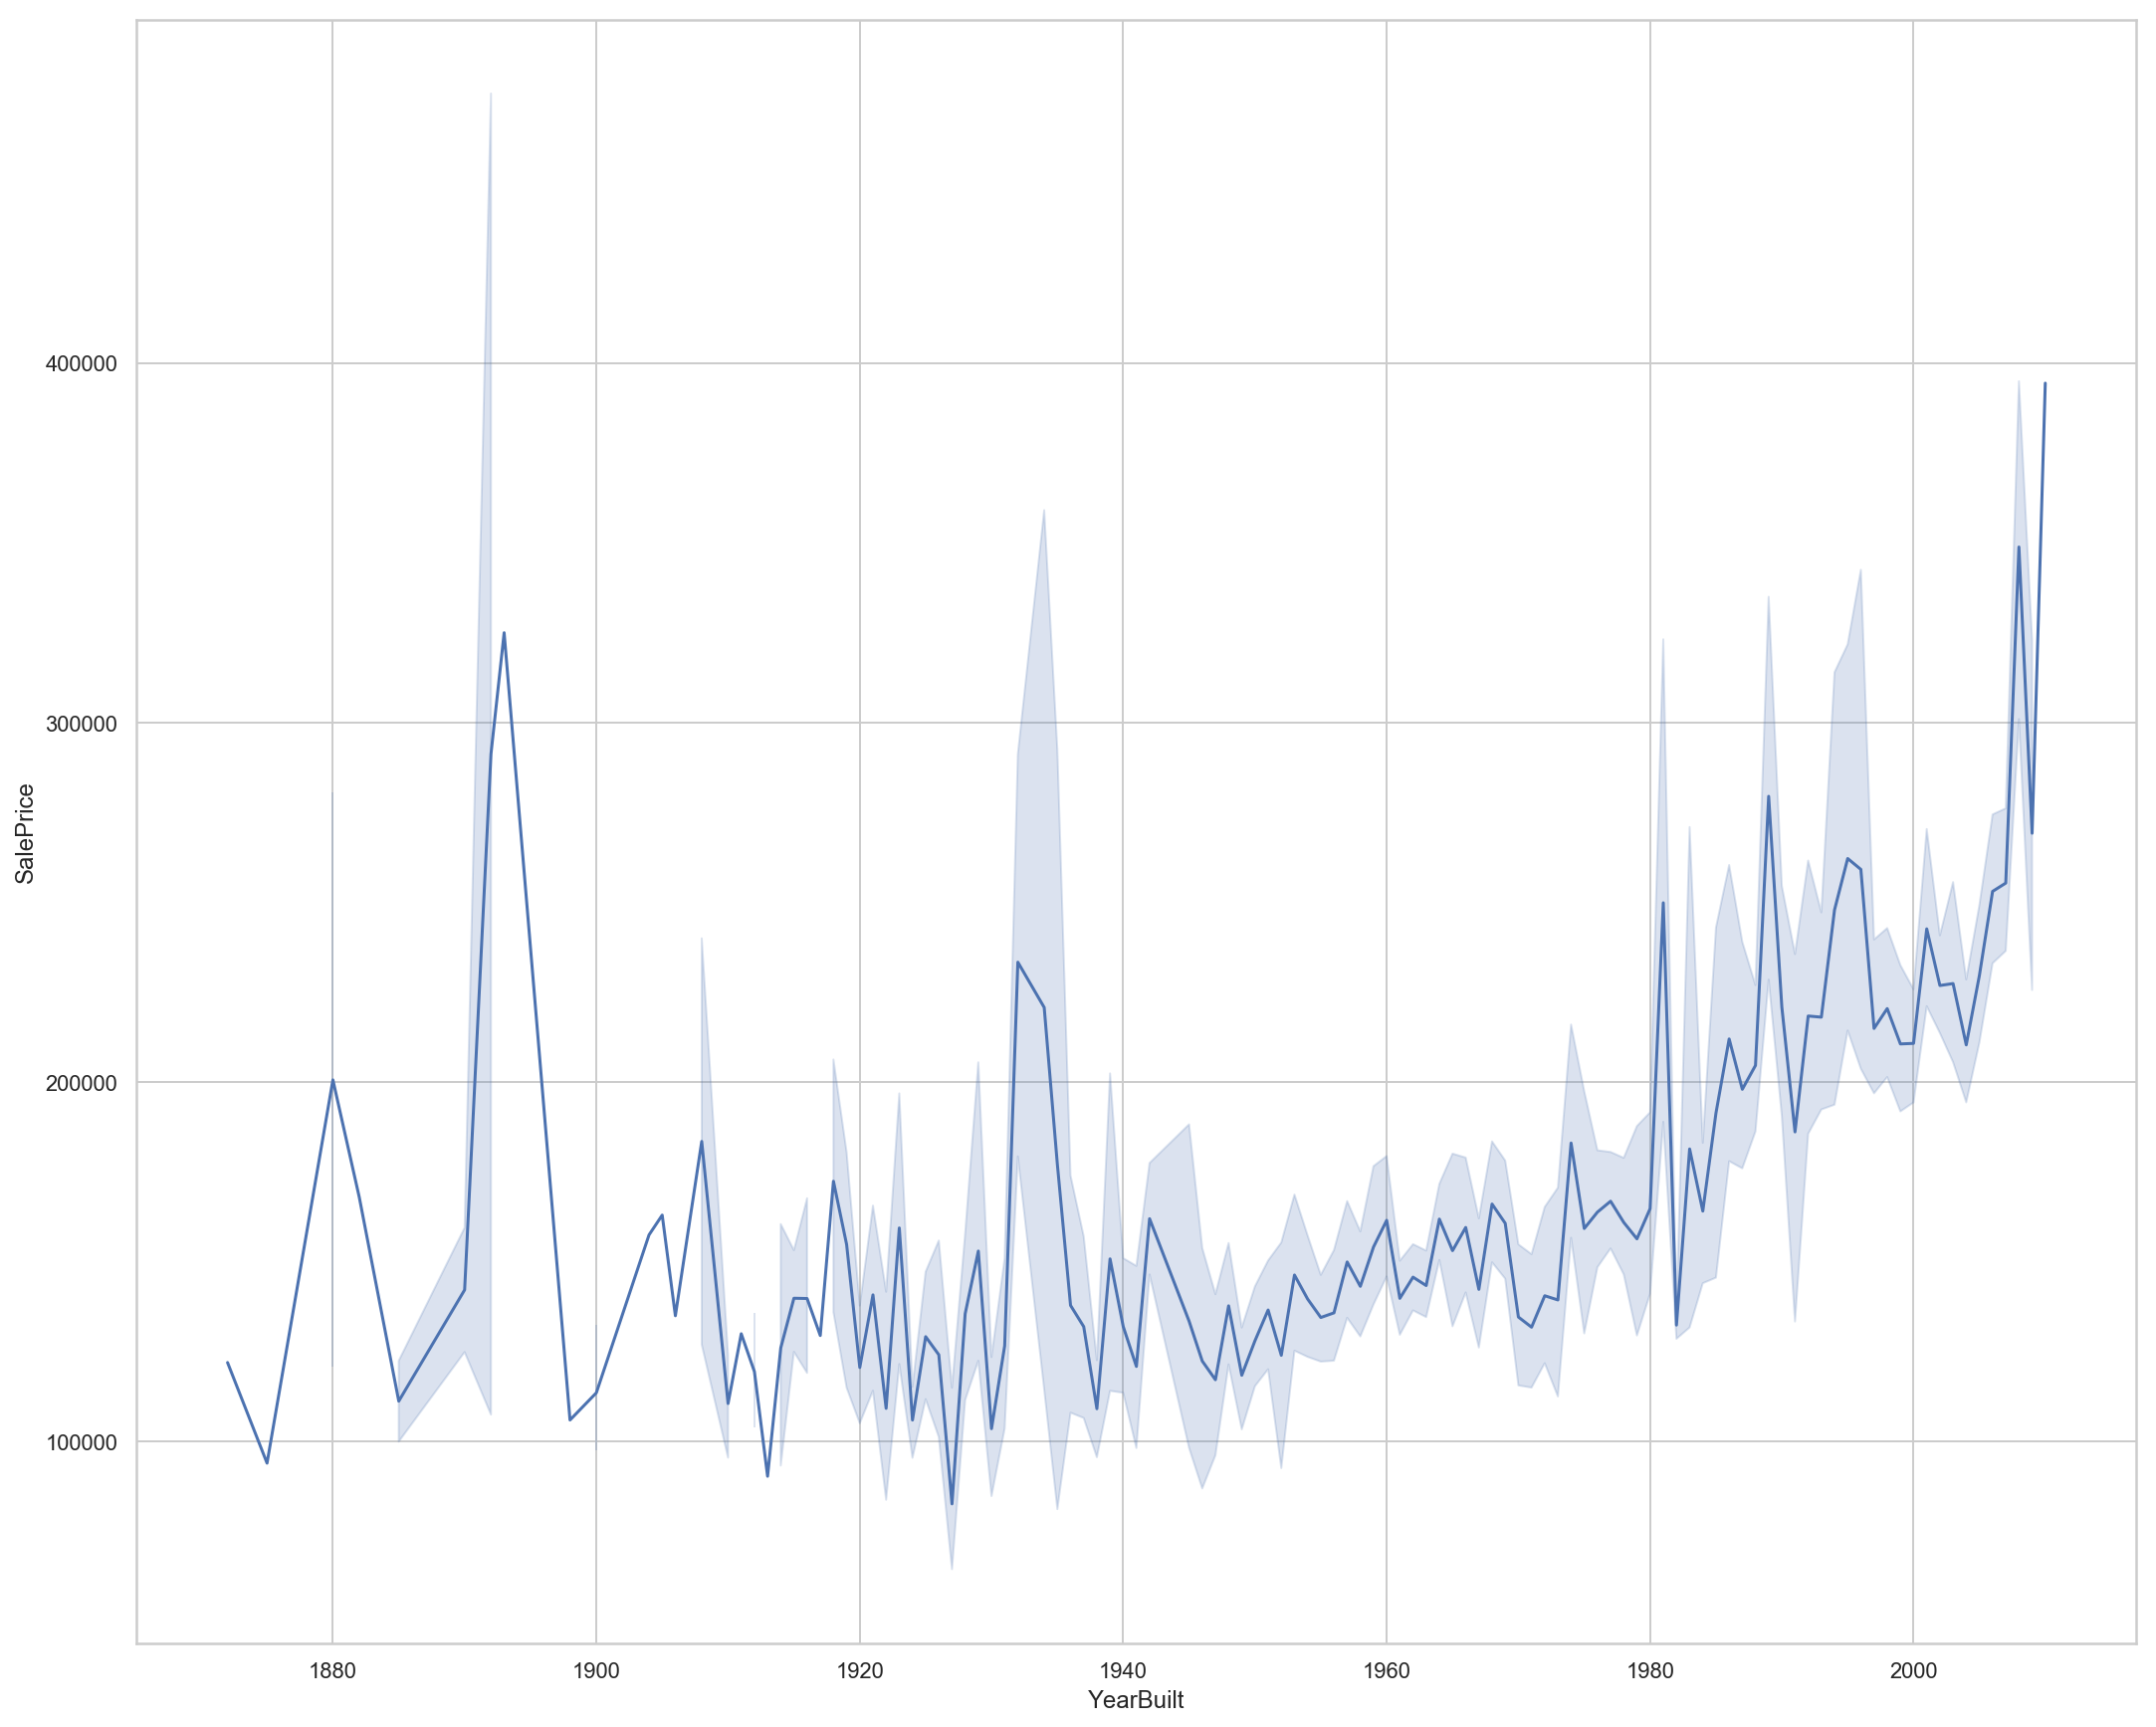

In [1602]:
plt.figure(figsize=(18,15))
ax = sns.lineplot(x="YearBuilt", y="SalePrice", dashes=False, data=Residential_house)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

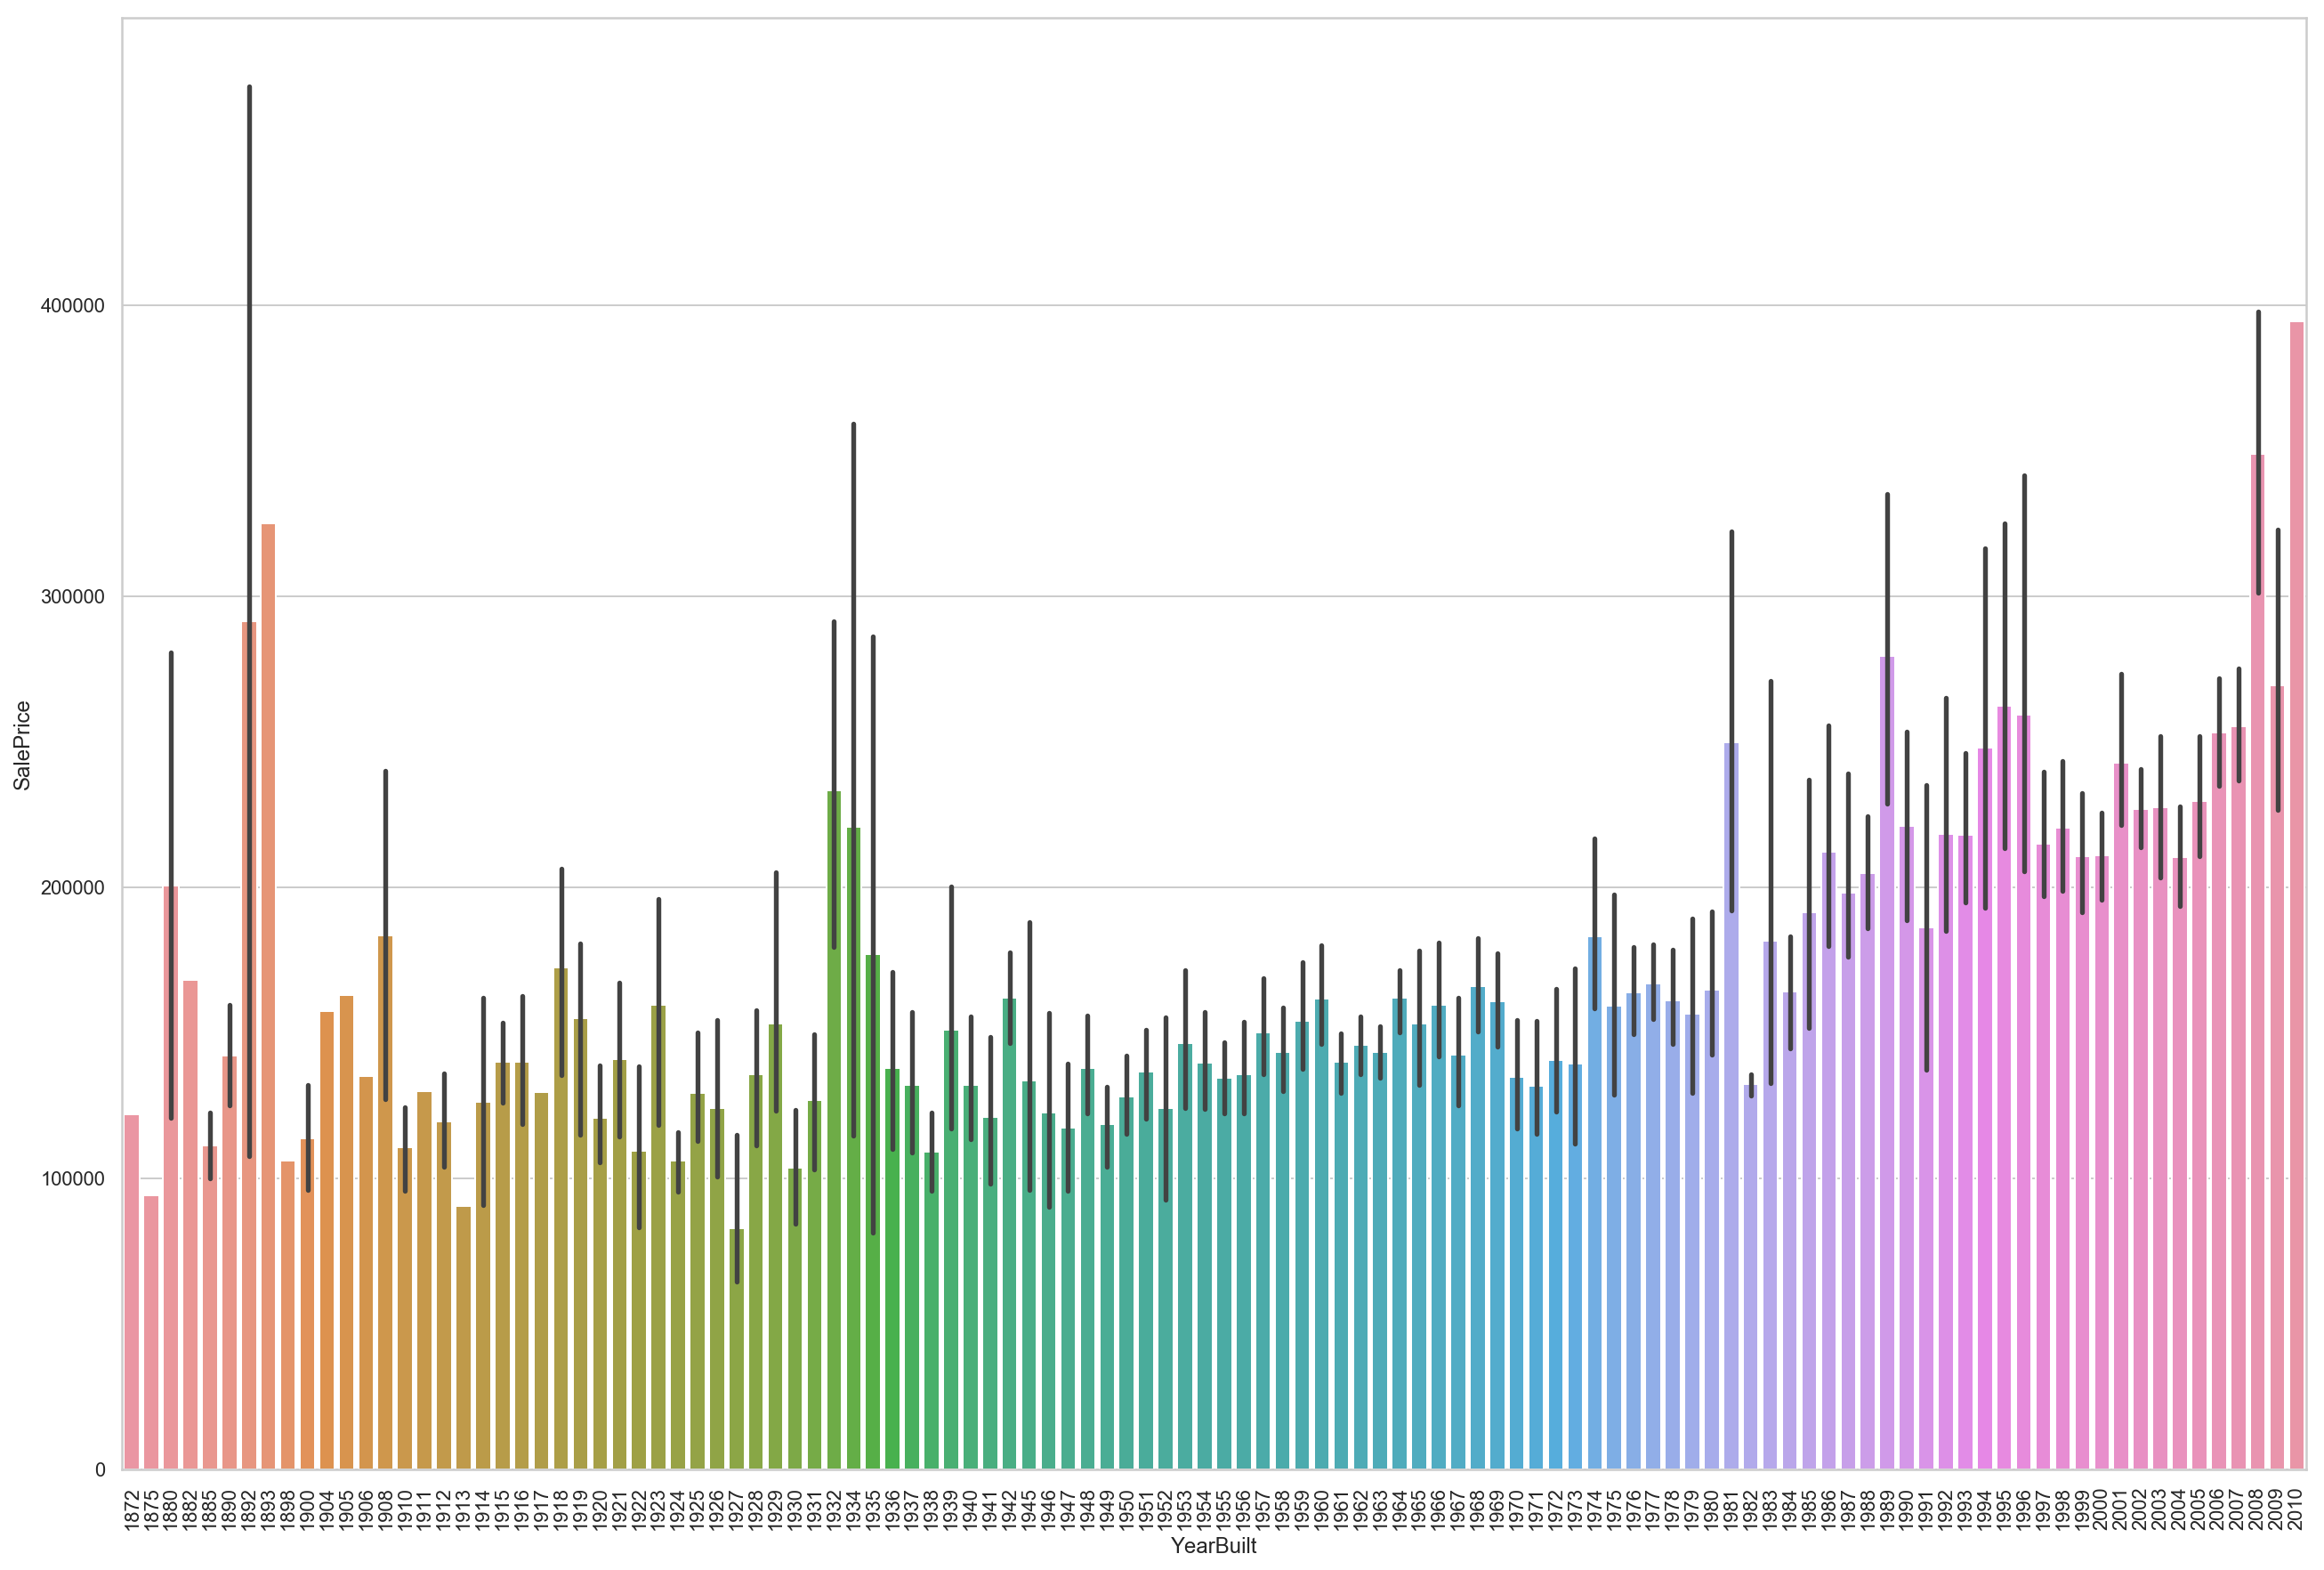

In [1603]:
plt.figure(figsize=(22,15))
sns.set(style="whitegrid")
ax = sns.barplot(x='YearBuilt', y='SalePrice', data=Residential_house)
plt.xticks(rotation=90)

In [1604]:
Residential_house['YrSold'].value_counts()

2009    336
2007    328
2006    312
2008    301
2010    172
Name: YrSold, dtype: int64

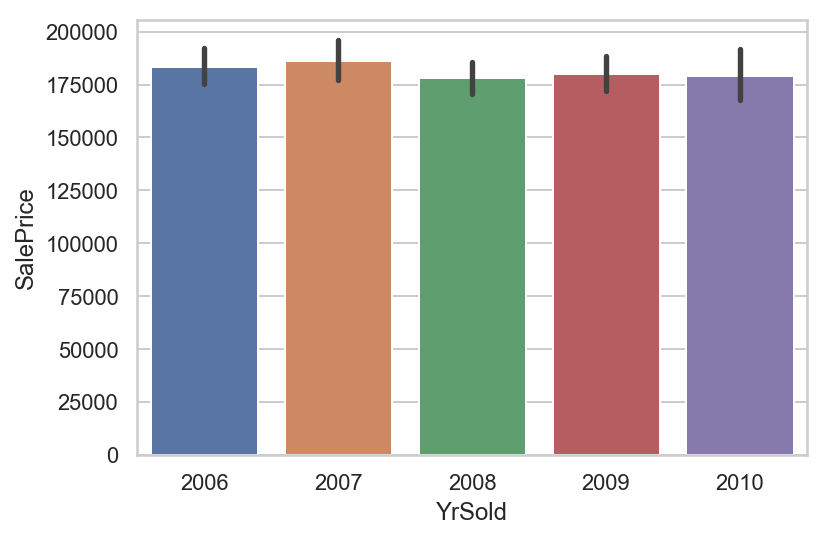

In [1605]:
sns.set(style="whitegrid")
ax = sns.barplot(x='YrSold', y='SalePrice', data=Residential_house)

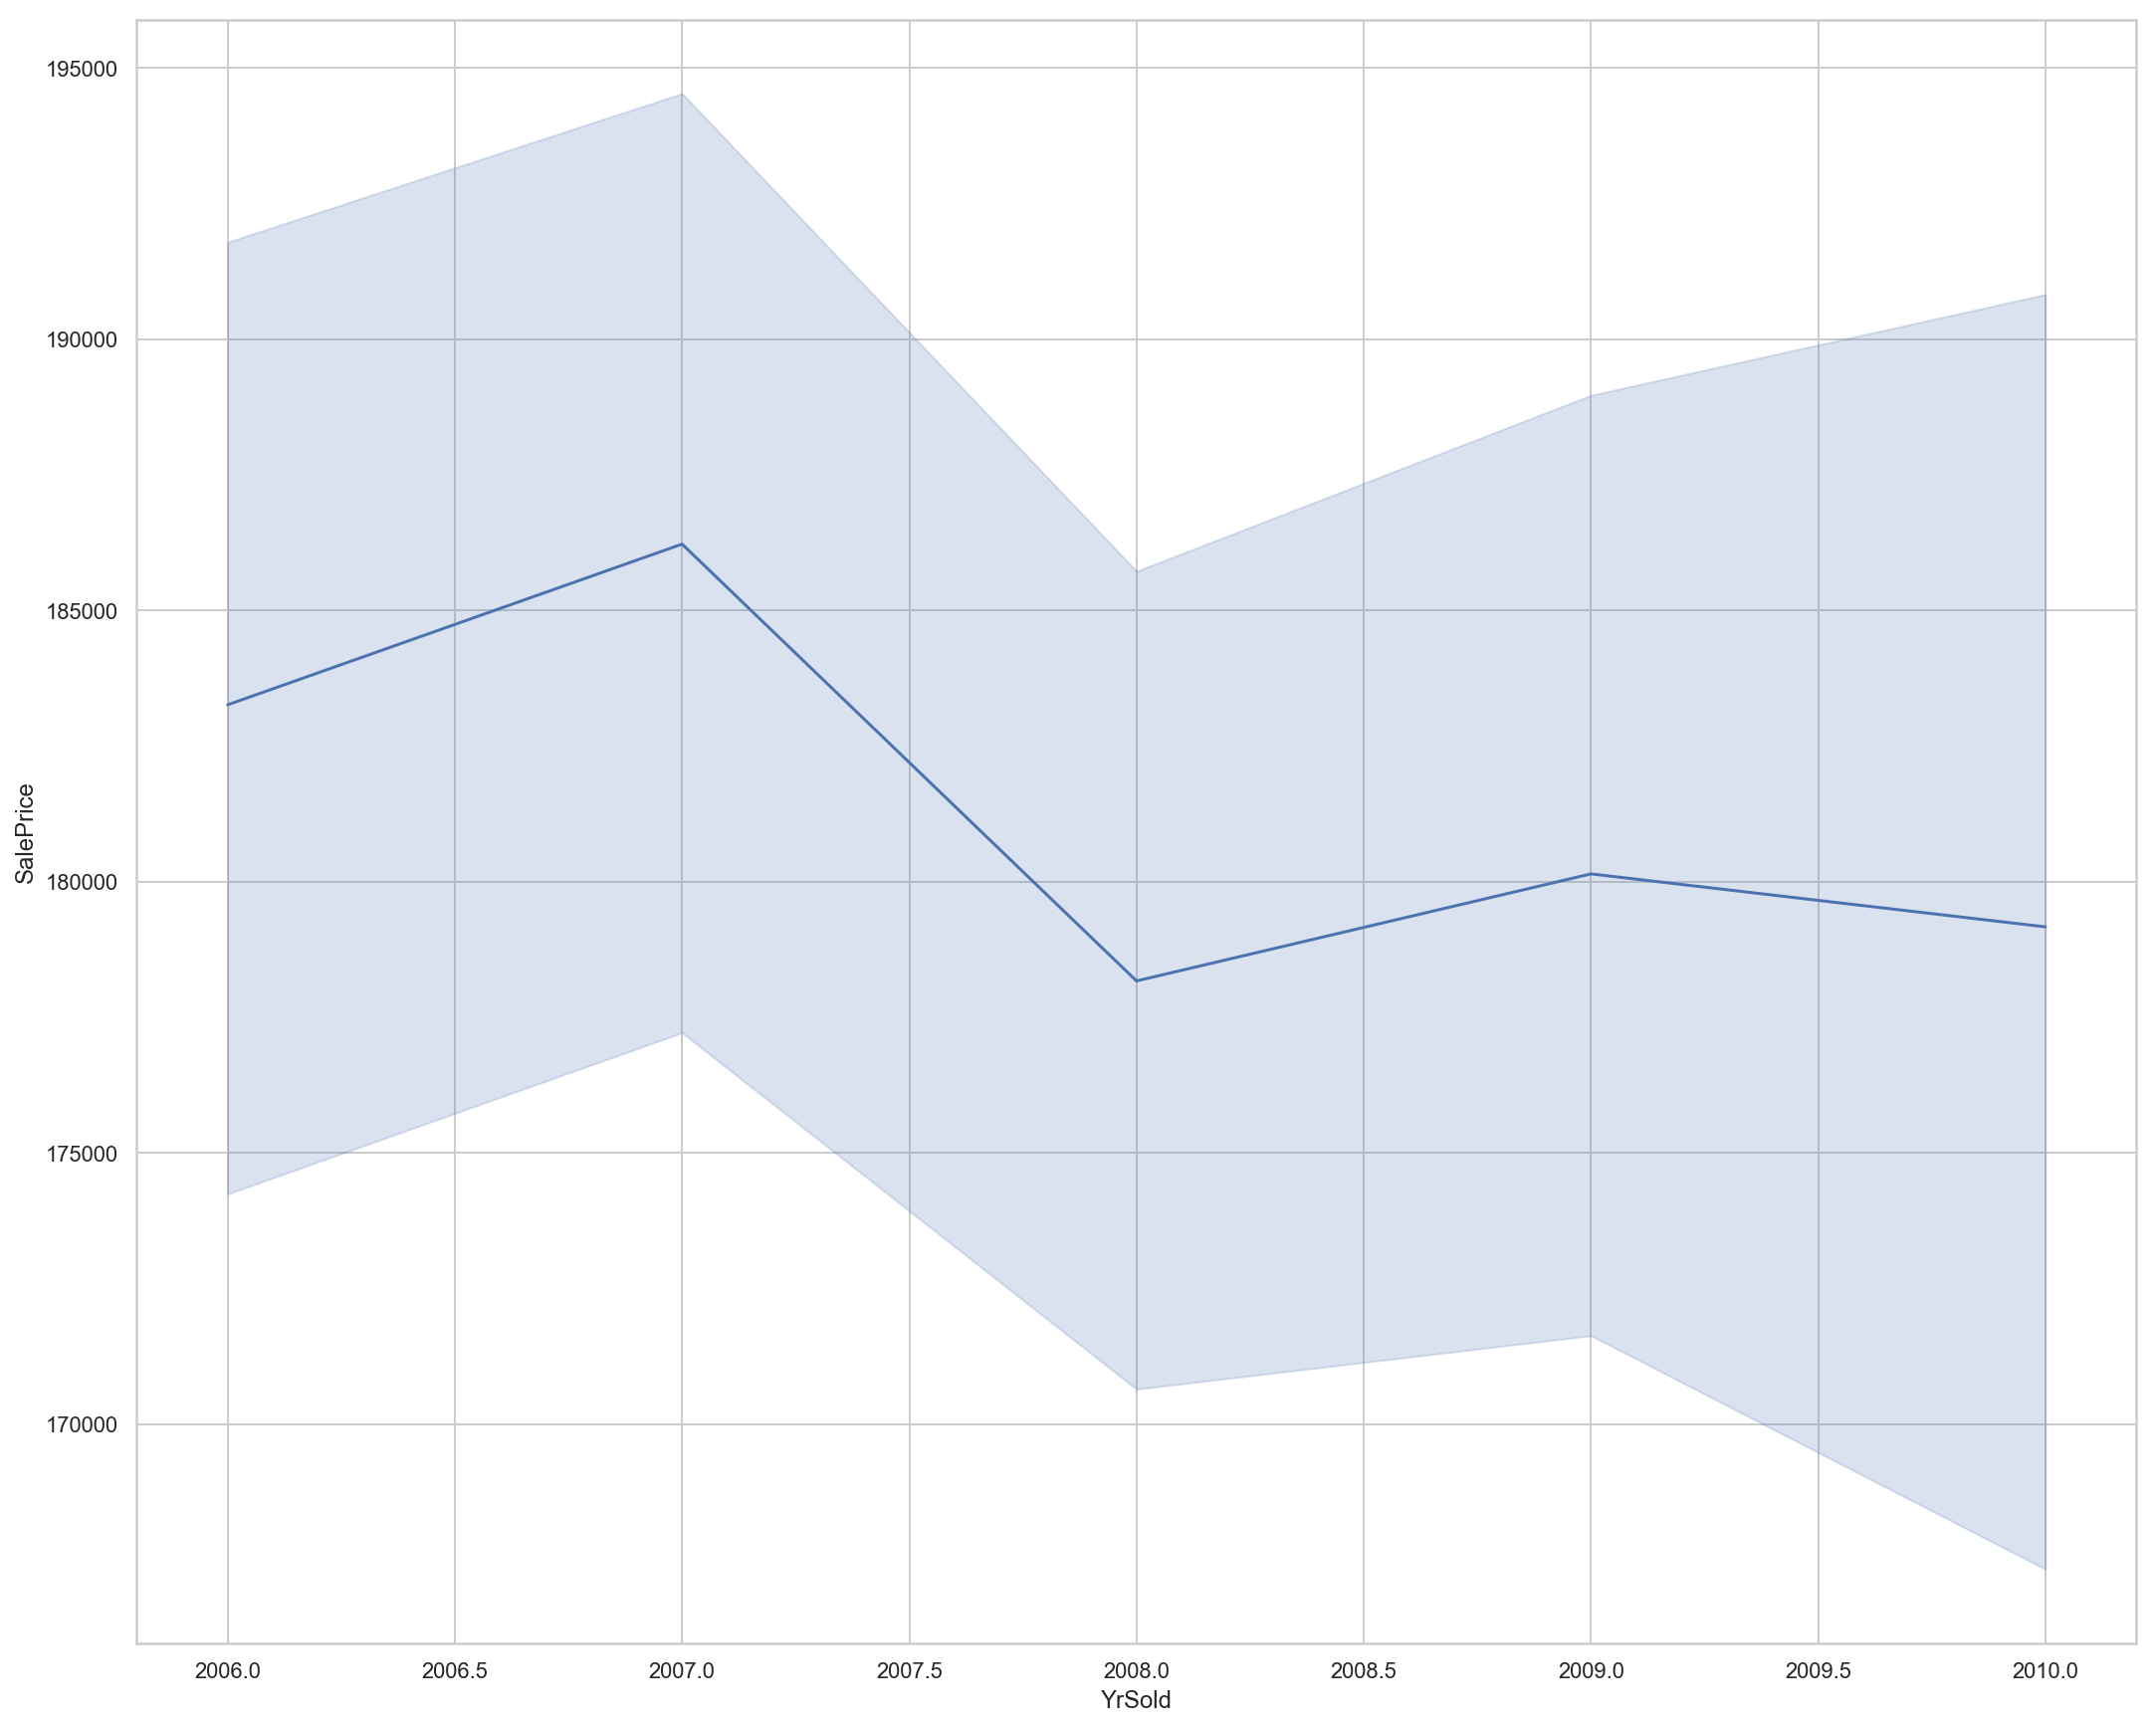

In [1606]:
plt.figure(figsize=(18,15))
ax = sns.lineplot(x="YrSold", y="SalePrice", data=Residential_house)

##### <b>General checking</b>

In [1607]:
Residential_house.filter(like='?', axis=0)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [1608]:
Residential_house.filter(like='-', axis=0)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [1609]:
Residential_house.filter(like='$', axis=0)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


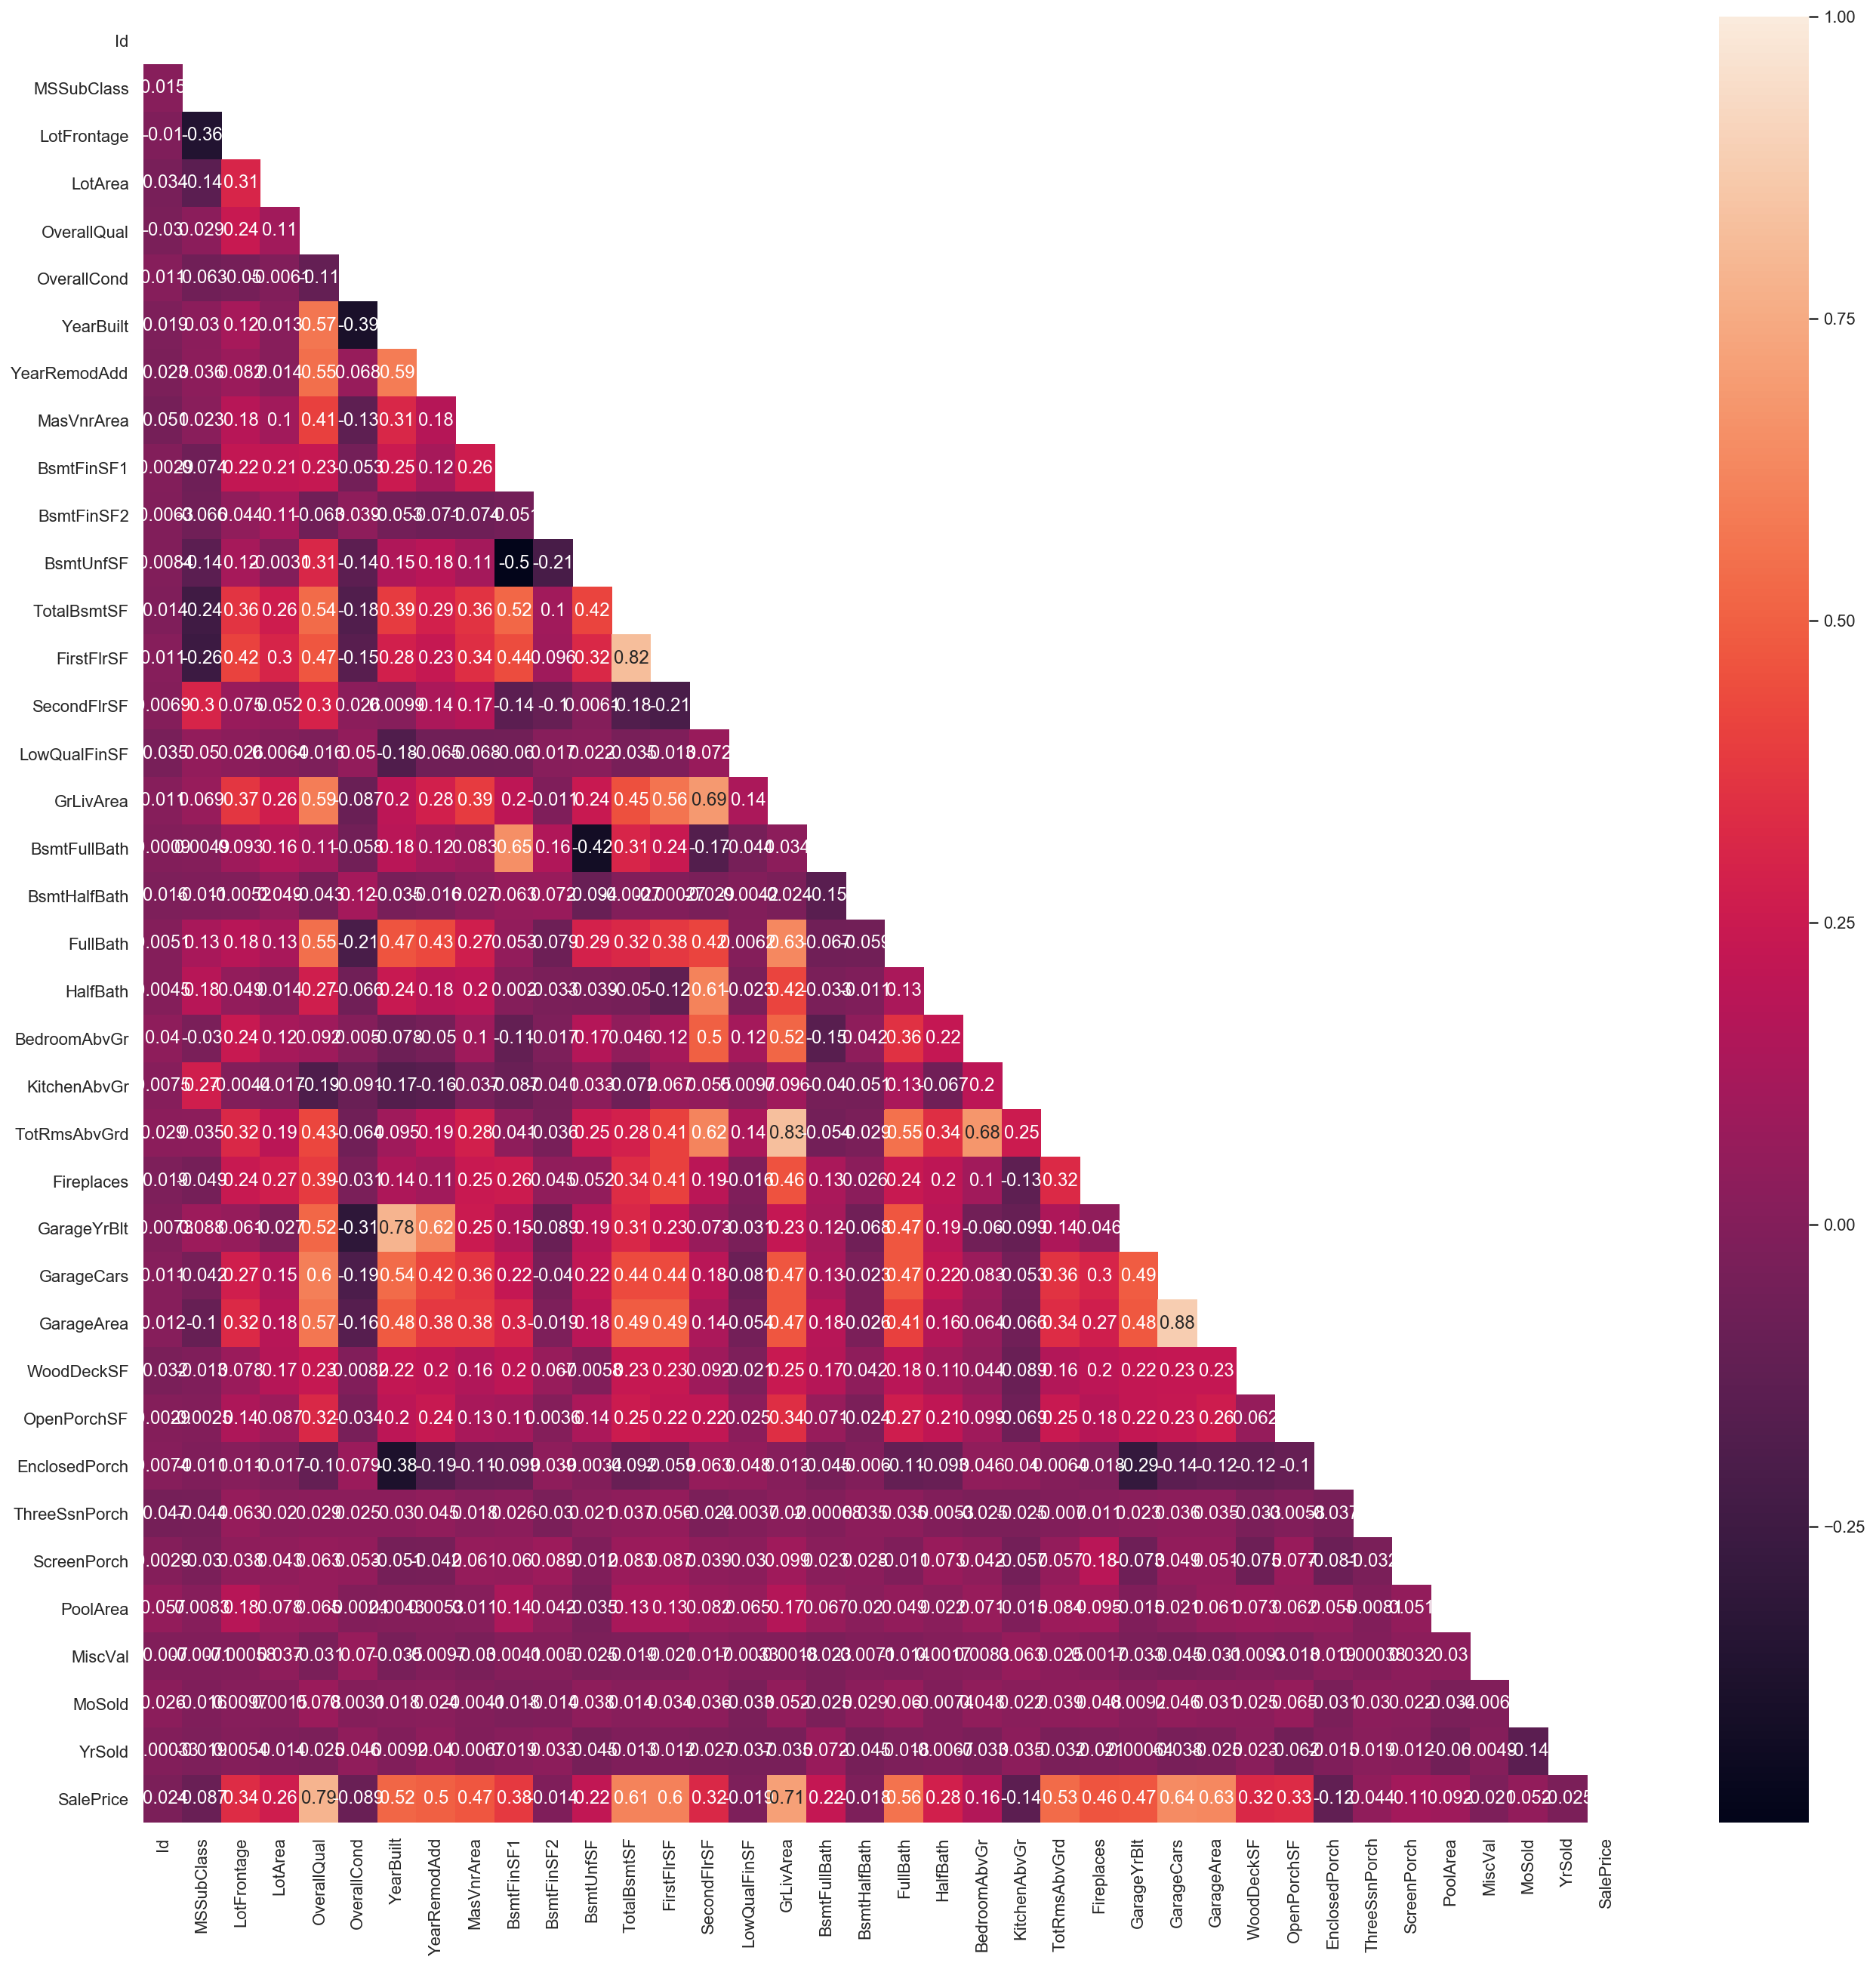

In [1610]:
plt.figure(figsize=(22,22))
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(Residential_house.corr(), dtype = np.bool )
mask[np.triu_indices_from(mask)] = True
# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.heatmap(Residential_house.corr( ), mask=mask, annot=True )

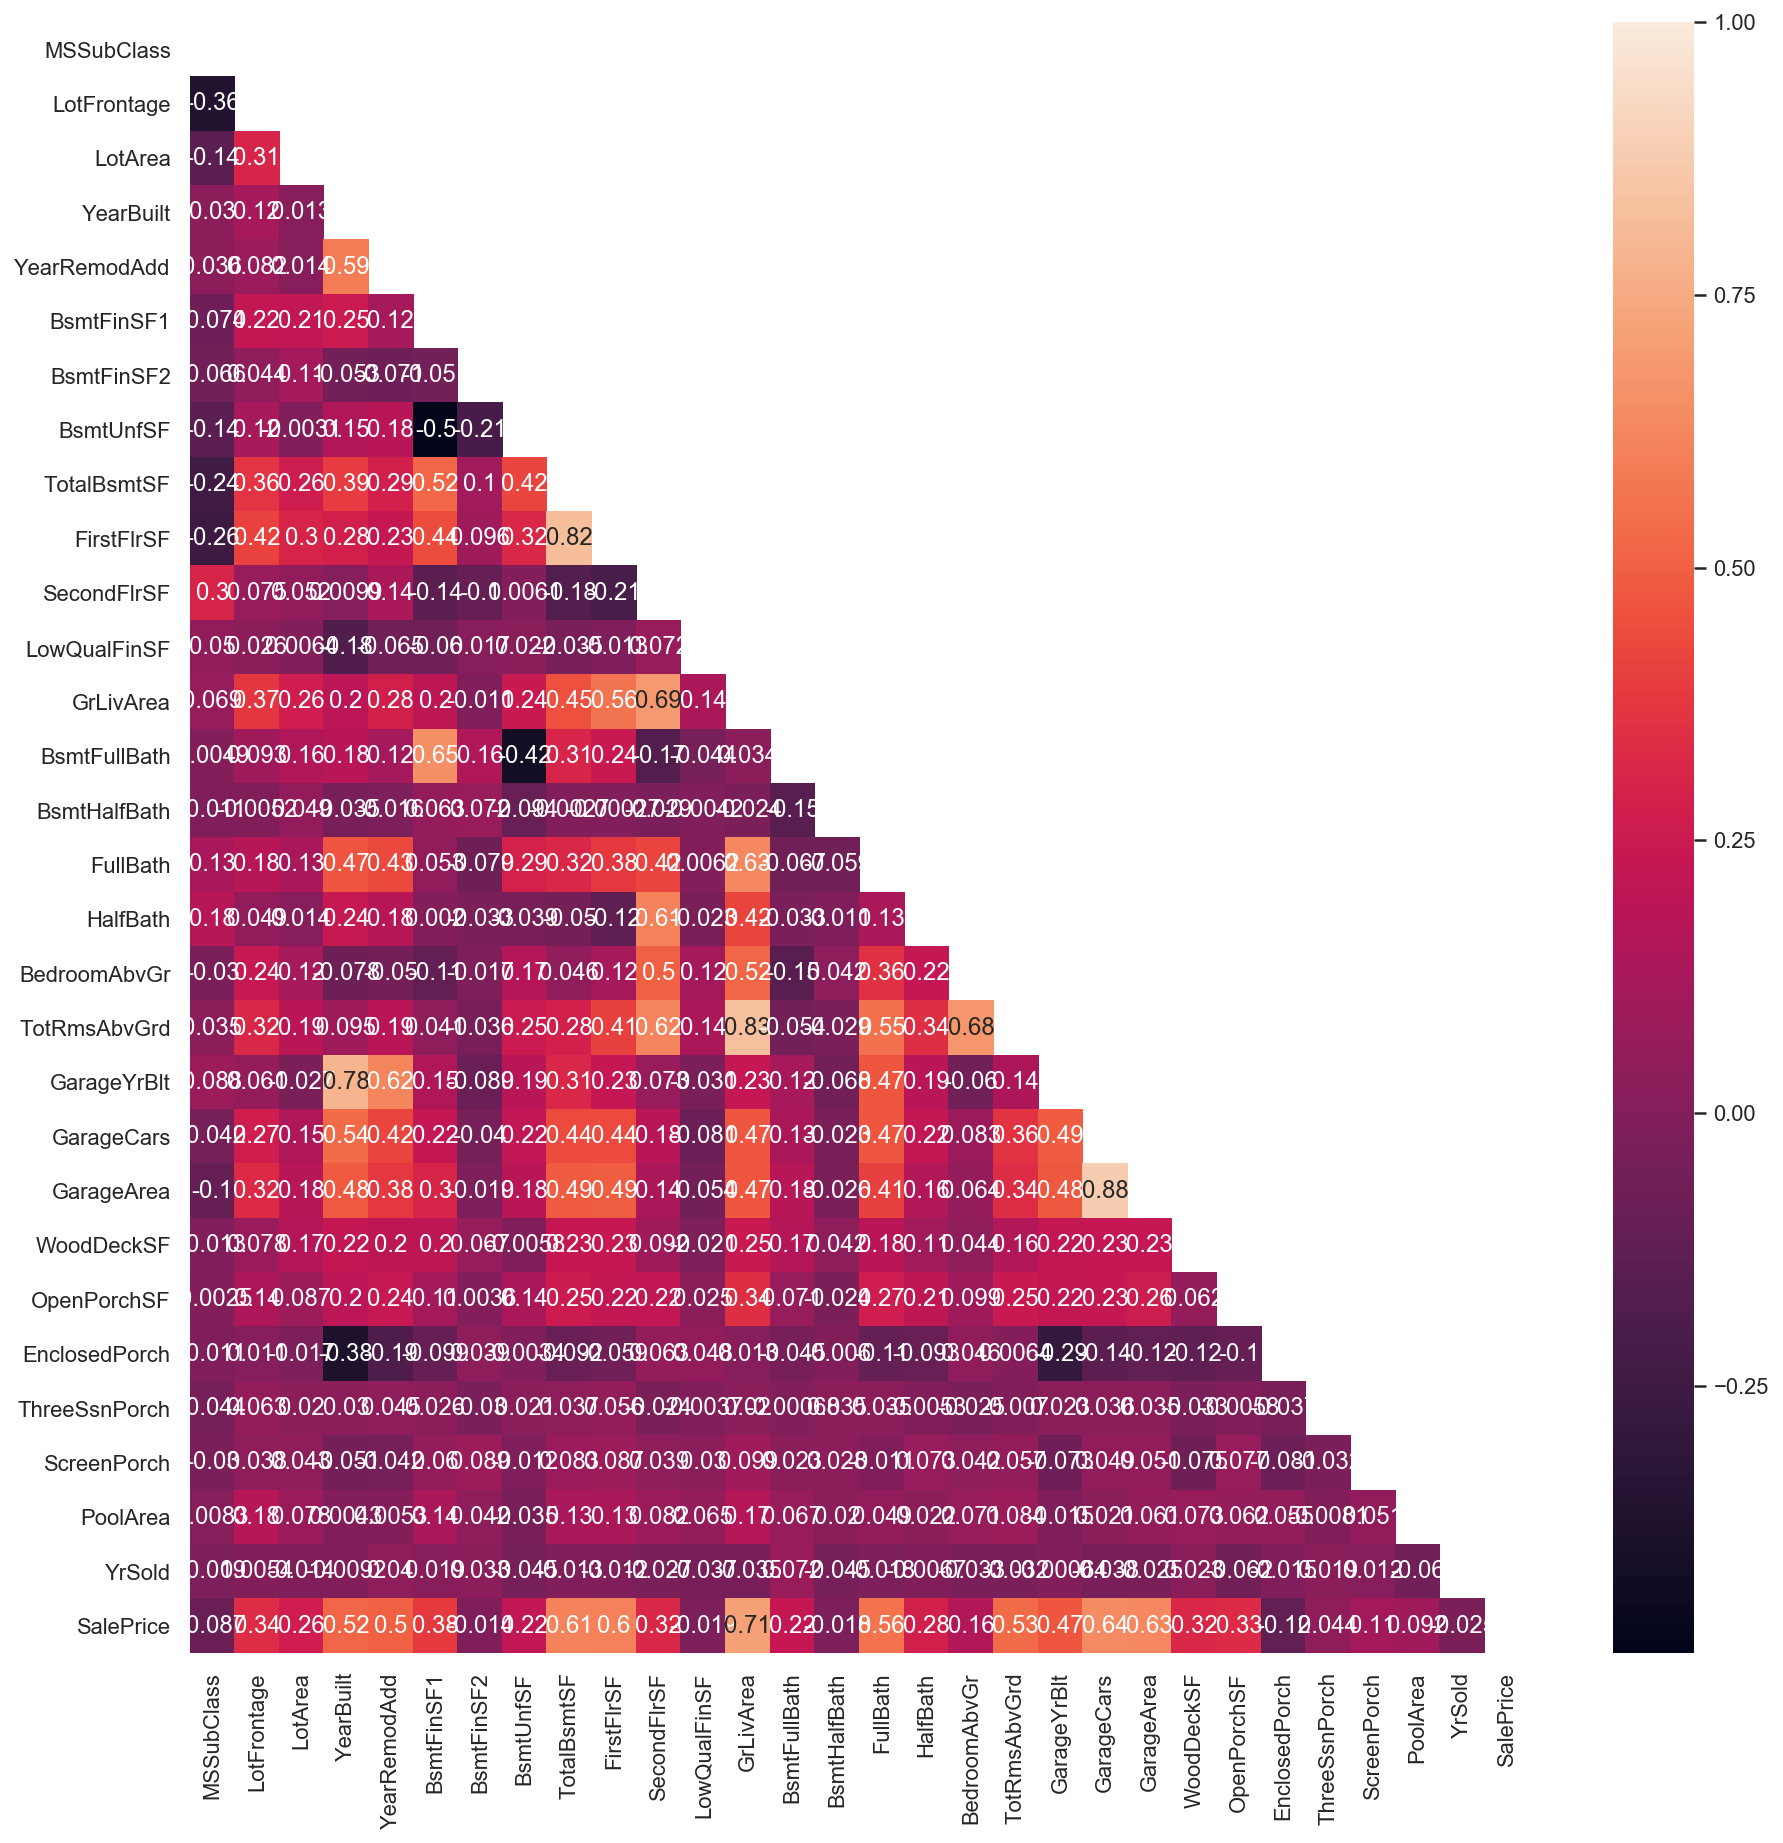

In [1611]:
X = Residential_house[['MSSubClass','MSZoning','LotFrontage','LotArea','Street' 
          ,'Alley','LotShape','LandContour','LotConfig','LandSlope','Neighborhood'
          ,'Condition1','Condition2','BldgType','YearBuilt','YearRemodAdd' 
          ,'Foundation','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF' 
          ,'FirstFlrSF','SecondFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath'
          ,'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','TotRmsAbvGrd'
          ,'Functional','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF' 
          ,'OpenPorchSF','EnclosedPorch','ThreeSsnPorch','ScreenPorch','PoolArea'
          ,'YrSold','SaleType','SaleCondition','SalePrice']]

plt.figure(figsize=(15,15))
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like( X.corr(), dtype = np.bool )
mask[np.triu_indices_from(mask)] = True
# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.heatmap( X.corr( ), mask=mask, annot=True )


In [1612]:
# Computing IQR to handle outliers - still under progress
#temp = Residential_house.copy()
#temp['SalePrice'] = (temp['SalePrice']-np.mean(temp['SalePrice']))/np.std(temp['SalePrice'])
#temp['LotArea'] = (temp['LotArea']-np.mean(temp['LotArea']))/np.std(temp['LotArea'])
Q1 = Residential_house['SalePrice'].quantile(0.25)
Q3 = Residential_house['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

Residential_house = Residential_house.query('(@Q1 - 1.5 * @IQR) <= SalePrice <= (@Q3 + 1.5 * @IQR)')
print("Before removing outliers : {}".format(house.shape))
print("After removing outliers : {}".format(Residential_house.shape))

Before removing outliers : (1460, 81)
After removing outliers : (1388, 81)


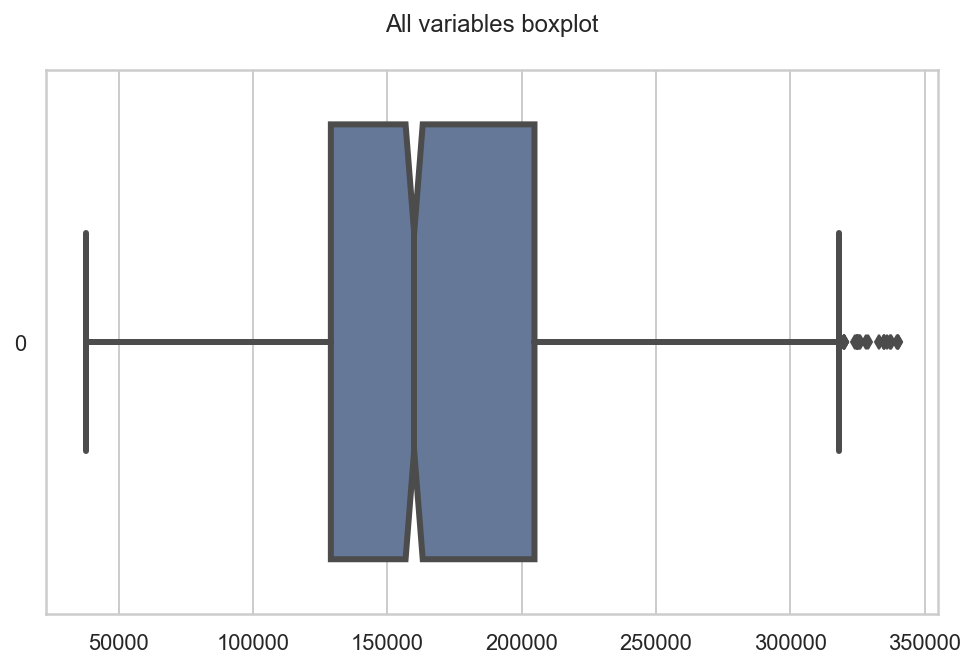

In [1613]:
# Checking outliers for Saleprice
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
ax = sns.boxplot(data=Residential_house['SalePrice'], orient='h', fliersize=5, linewidth=3, notch=True, saturation=0.5, ax=ax)
ax.set_title('All variables boxplot\n')
plt.show()

#### Assigning non-renovateable features

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'FirstFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

In [1614]:
# X includes non-renovateable features.
# check with others for Alley, BsmtExposure, BsmtFinType1, BsmtFinType2, GarageType
# MiscFeature, MiscVal
# X = Residential_house['MSSubClass','MSZoning','LotFrontage','LotArea','Street' 
#           ,'Alley','LotShape','LandContour','LotConfig','LandSlope','Neighborhood'
#           ,'Condition1','Condition2','BldgType','YearBuilt','YearRemodAdd' 
#           ,'Foundation','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF' 
#           ,'FirstFlrSF','SecondFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath'
#           ,'BsmtHalfBath','FullBath','HalfBath','Bedroom','TotRmsAbvGrd'
#           ,'Functional','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF' 
#           ,'OpenPorchSF','EnclosedPorch','ThreeSsnPorch','ScreenPorch','PoolArea'
#           ,'YrSold','SaleType','SaleCondition']

formula = 'SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotArea + Street \
          + Alley + LotShape + LandContour + LotConfig + LandSlope + Neighborhood \
          + Condition1 + Condition2 + BldgType + YearBuilt + YearRemodAdd \
          + Foundation + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF \
          + FirstFlrSF + SecondFlrSF + LowQualFinSF + GrLivArea + BsmtFullBath \
          + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + TotRmsAbvGrd \
          + Functional + GarageYrBlt + GarageCars + GarageArea + WoodDeckSF \
          + OpenPorchSF + EnclosedPorch + ThreeSsnPorch + ScreenPorch + PoolArea \
          + YrSold + SaleType + SaleCondition - 1'

#formula = 'SalePrice ~ MSSubClass + MSZoning + LotFrontage + LotArea - 1'

y, X = patsy.dmatrices(formula, data=Residential_house, return_type='dataframe')

In [1615]:
list(X.columns)

['MSZoning[FV]',
 'MSZoning[RH]',
 'MSZoning[RL]',
 'MSZoning[RM]',
 'Street[T.Pave]',
 'Alley[T.NA]',
 'Alley[T.Pave]',
 'LotShape[T.IR2]',
 'LotShape[T.IR3]',
 'LotShape[T.Reg]',
 'LandContour[T.HLS]',
 'LandContour[T.Low]',
 'LandContour[T.Lvl]',
 'LotConfig[T.CulDSac]',
 'LotConfig[T.FR2]',
 'LotConfig[T.FR3]',
 'LotConfig[T.Inside]',
 'LandSlope[T.Mod]',
 'LandSlope[T.Sev]',
 'Neighborhood[T.Blueste]',
 'Neighborhood[T.BrDale]',
 'Neighborhood[T.BrkSide]',
 'Neighborhood[T.ClearCr]',
 'Neighborhood[T.CollgCr]',
 'Neighborhood[T.Crawfor]',
 'Neighborhood[T.Edwards]',
 'Neighborhood[T.Gilbert]',
 'Neighborhood[T.IDOTRR]',
 'Neighborhood[T.MeadowV]',
 'Neighborhood[T.Mitchel]',
 'Neighborhood[T.NAmes]',
 'Neighborhood[T.NPkVill]',
 'Neighborhood[T.NWAmes]',
 'Neighborhood[T.NoRidge]',
 'Neighborhood[T.NridgHt]',
 'Neighborhood[T.OldTown]',
 'Neighborhood[T.SWISU]',
 'Neighborhood[T.Sawyer]',
 'Neighborhood[T.SawyerW]',
 'Neighborhood[T.Somerst]',
 'Neighborhood[T.StoneBr]',
 'Neighbo

In [1616]:
len(X.columns)

115

In [1617]:
X.rename(columns={'MSZoning[FV]':'MSZoning[T.FV]',
                  'MSZoning[RH]':'MSZoning[T.RH]', 
                  'MSZoning[RL]':'MSZoning[T.RL]',
                  'MSZoning[RM]':'MSZoning[T.RM]'}, inplace=True)

In [1618]:
# Function for dropping reference dummy column. The funciton will drop if it's the column contains NA or None. 
# If values, it'll drop the smallest value as reference.
# If the necessary column is not dropped, it'll not drop anymore and just give message as info that related column has been dropped.
def drop_dummy(column):
#     print(column,":")
#     print(Residential_house[column].value_counts(ascending=True))
    try:
        if column in Columns_NA: 
            drop_col_name = column + '[T.NA]'
            X.drop(drop_col_name, axis=1, inplace=True)
            print(column,":")
            print(Residential_house[column].value_counts(ascending=True))
            print("Drop column : {}".format(drop_col_name))
        elif column in Columns_None:
            drop_col_name = column + '[T.None]'
            X.drop(drop_col_name, axis=1, inplace=True)
            print(column,":")
            print(Residential_house[column].value_counts(ascending=True))
            print("Drop column : {}".format(drop_col_name))
        else:
            drop_col_name = column + '[T.' + Residential_house[column].\
                                            value_counts(ascending=True).index[0] + ']'
            X.drop(drop_col_name, axis=1, inplace=True)
            print(column,":")
            print(Residential_house[column].value_counts(ascending=True))
            print("Drop column : {}".format(drop_col_name))
    except:
        print(column," was performed drop_dummy.")
    print("_"*80)

In [1619]:
# Checking all columns in X is dummies columns and if so, call the funciton to drop dummy reference columns which the function will determine what to drop
for x in X.columns:
    if 'T.' in x and '[' in x:
        # get the column name and pass it to drop_dummy function to drop reference columns
        drop_dummy(x.split('[')[0])

MSZoning :
RH      16
FV      64
RM     216
RL    1092
Name: MSZoning, dtype: int64
Drop column : MSZoning[T.RH]
________________________________________________________________________________
MSZoning  was performed drop_dummy.
________________________________________________________________________________
MSZoning  was performed drop_dummy.
________________________________________________________________________________
MSZoning  was performed drop_dummy.
________________________________________________________________________________
Street  was performed drop_dummy.
________________________________________________________________________________
Alley :
Pave      39
Grvl      50
NA      1299
Name: Alley, dtype: int64
Drop column : Alley[T.NA]
________________________________________________________________________________
Alley  was performed drop_dummy.
________________________________________________________________________________
LotShape :
IR3      9
IR2     35
IR1    456
Re

In [1620]:
len(X.columns)

101

In [1621]:
X.shape

(1388, 101)

In [1622]:
y.shape

(1388, 1)

In [1623]:
# intercept is not required for sklearn
#X['intercept'] = 1

#### <b>Using Multi-Linear Regression for model</b>

##### <b>Splitting Data, Standardize X_train datatset and Fit with LinearRegression</b>

In [1624]:
X['YrSold'].dtypes

dtype('float64')

In [1625]:
train_dataset = X[X['YrSold']!=2010]
train_dataset.shape

(1222, 101)

In [1626]:
test_dataset = X[X['YrSold']==2010]
test_dataset.shape

(166, 101)

In [1627]:
X_y = pd.concat([X,y],axis=1)
X_y.head()

,MSZoning[T.FV],MSZoning[T.RL],MSZoning[T.RM],Street[T.Pave],Alley[T.Pave],LotShape[T.IR2],LotShape[T.Reg],LandContour[T.HLS],LandContour[T.Lvl],LotConfig[T.CulDSac],...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,YrSold,SalePrice
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,548.0,0.0,61.0,0.0,0.0,0.0,0.0,2008.0,208500.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,2.0,460.0,298.0,0.0,0.0,0.0,0.0,0.0,2007.0,181500.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,608.0,0.0,42.0,0.0,0.0,0.0,0.0,2008.0,223500.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.0,642.0,0.0,35.0,272.0,0.0,0.0,0.0,2006.0,140000.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.0,836.0,192.0,84.0,0.0,0.0,0.0,0.0,2008.0,250000.0


In [1628]:
# Splitting the data to train and test
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
X_y = pd.concat([X,y],axis=1)
train_dataset = X_y[X_y['YrSold']!=2010]
test_dataset = X_y[X_y['YrSold']==2010]
X_train = train_dataset[train_dataset.columns.difference(['SalePrice'])].values
y_train = train_dataset['SalePrice'].values
X_test = test_dataset[test_dataset.columns.difference(['SalePrice'])].values
y_test = test_dataset['SalePrice'].values

# Instantiate StandardScaler()
ss = StandardScaler()

# Use the "fit_transform" function to standardize the X design matrix.
Xs_train = ss.fit_transform(X_train)

# Instantiate Linear Regression Model
linreg = LinearRegression()

# Fit the model on the train dataset of X and Y.
linreg.fit(Xs_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [1629]:
# Getting coefficients of the model
linreg.coef_

array([-6.96943509e+02, -2.19061833e+03, -2.99080780e+03, -4.35986190e+03,
       -4.67673615e+03, -8.99332641e+16, -3.25150834e+16,  5.47288242e+03,
        1.34916327e+03, -9.01757243e+16, -8.06000000e+02,  3.70700000e+03,
        8.12000000e+02,  1.66900000e+03, -5.71000000e+02,  7.06500000e+02,
        1.49900000e+03, -4.29250000e+02,  1.31525000e+03,  3.90400000e+03,
       -6.34800000e+03,  1.05500000e+02,  4.79500000e+02,  1.57870312e+03,
       -3.35285597e+16,  3.64000000e+02,  2.42800000e+03, -2.25850000e+03,
        1.47000000e+02,  1.16750000e+03, -7.00000000e+02,  1.44000000e+03,
        1.21700000e+03,  8.06000000e+02,  6.99600000e+03, -2.04350000e+03,
        9.36200000e+03, -1.54800000e+03,  4.52002186e+16, -9.00000000e+02,
        1.27050000e+03,  1.69800000e+03,  2.16500000e+03,  2.78400000e+03,
        1.38900000e+03, -1.23850000e+03, -1.10000000e+02, -1.89950000e+03,
       -2.00000000e+00, -1.08800000e+03, -4.41620224e+15, -3.26600000e+03,
       -8.68000000e+02,  

In [1630]:
# Getting intercept of the model
linreg.intercept_

171131.21551654494

In [1631]:
# Use the KFold class to add more options.
kf_shuffle = KFold(n_splits=10,shuffle=True, random_state=42) 

#The function cross_val_score returns the  𝑅2  for each testing set.
scores = cross_val_score(linreg, Xs_train, y_train, cv=kf_shuffle)

print("R2 scores for 10 folds : {}".format(scores))
print("R2 mean : {}, R2 std : {}".format(np.mean(scores), np.std(scores)))

R2 scores for 10 folds : [-5.55606576e+18  8.72144233e-01  8.05947988e-01  8.36129641e-01
  9.12920597e-02 -4.00426231e+21  8.42881171e-01  8.27276499e-01
  8.24190164e-01 -3.77085418e+21]
R2 mean : -7.780672554800221e+20, R2 std : 1.555622133357697e+21


In [1648]:
# With training data set
predictions = linreg.predict(Xs_train)
print("RMSE for whole train dataset:", np.sqrt(metrics.mean_squared_error(y_train, predictions)))

RMSE for whole train dataset: 22154.816685513662


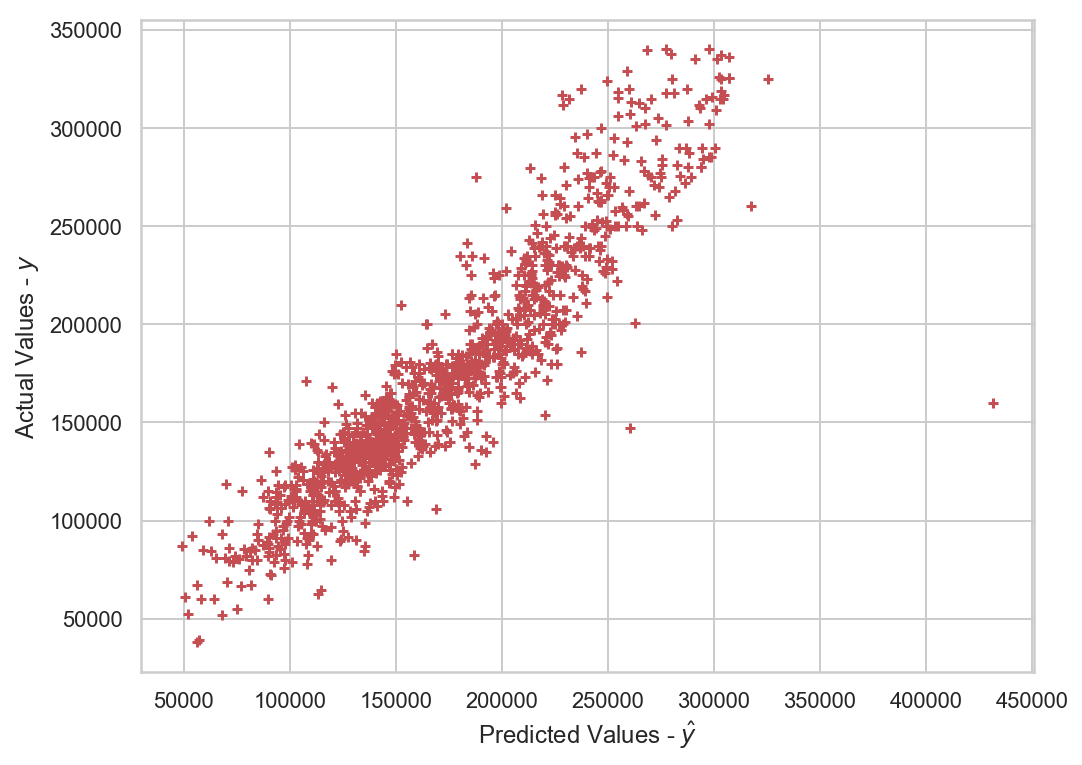

In [1633]:
# Plot the model with training dataset
plt.figure(figsize=(8,6))
plt.scatter(predictions, y_train, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

In [1634]:
# With test data set
Xs_test = ss.fit_transform(X_test)
predictions = linreg.predict(Xs_test)
print("RMSE for whole test dataset:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE for whole dataset: 1.373302035421418e+16


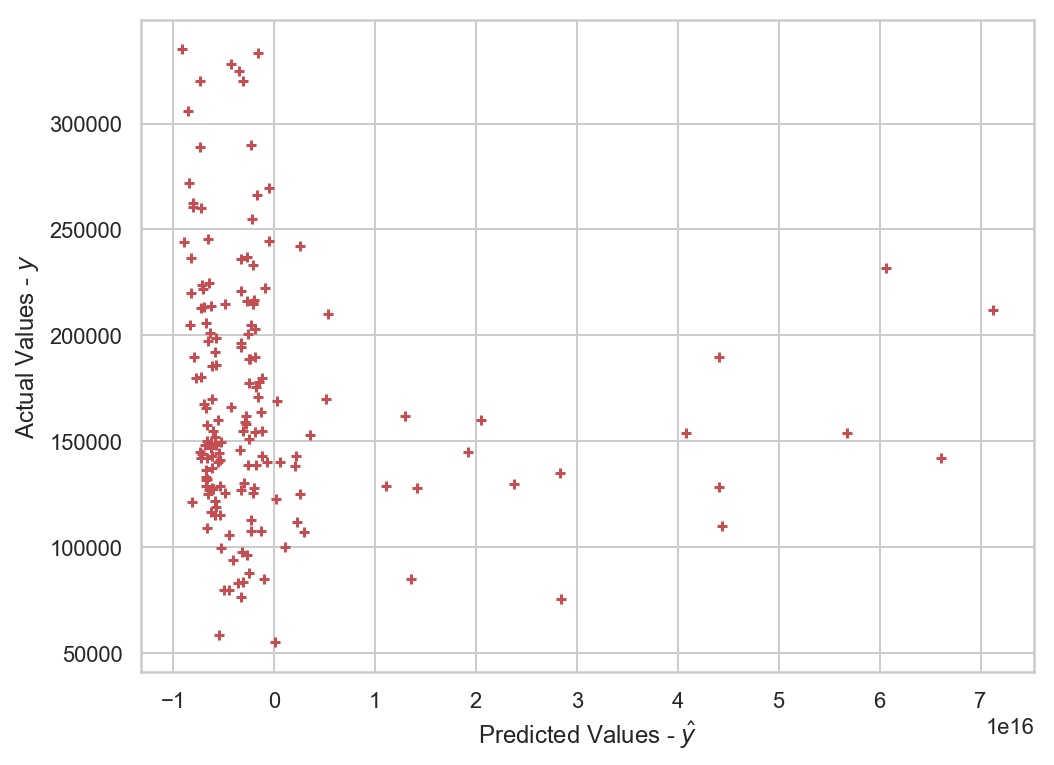

In [1635]:
# Plot the model with test dataset
plt.figure(figsize=(8,6))
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

#### <b>Using Ridge for regularization with alpha 0.1</b>

In [1636]:
# try alpha=0.1
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(Xs_train, y_train)
print(ridgereg.coef_)
print('Ridge train score : {}'.format(ridgereg.score(Xs_train,y_train)))

y_pred = ridgereg.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

[ -672.40207296 -1289.35838691 -3178.52073085 -2080.45816532
 -2947.2124789   1875.09110178   606.99108333  4593.54567787
  1048.34301827   308.06824175 -1450.00333862  2604.42626796
   735.68410942  1161.02420392  -856.99890222   152.72921626
  1477.34420876  -450.37203793  1390.79839656  3129.98583131
 -5235.42406523    53.47104235   431.44072308  1041.20574134
  7235.45970321    26.91315494  2907.77402691 -1305.58766841
    57.42652622  3119.41433742 -1116.35031961   138.17850689
  -272.96931233   -21.51151284  4277.18972168  1743.60961042
  6754.14280736  -220.71897254 11219.34673437   994.6791952
  1012.71758248  1437.71663593  1997.75111947  2409.33486769
  1730.0459843  -1253.36902989   -33.98929797  -733.58718853
    16.76506842 -1217.08034819  -586.66778083 -2939.15138703
   141.04194871  1798.78450305 -1050.77754677    36.2982851
   832.41680986   638.3168929  -1108.75852369  3725.04585
 -3672.3375096  -2526.77247421  -430.91291274 -1110.01532235
 -2875.91090878 -2622.4640019

In [1637]:
# # Finding alpha in manual way for Ridge
# error = []
# # Use the KFold class to add more options.
# kf_shuffle = KFold(n_splits=5,shuffle=True, random_state=42)
# for number in np.logspace(-5, 10, 500):
#     ridgereg = Ridge(alpha = number, normalize=True)
#     ridgereg.fit(Xs_train, y_train)
#     y_pred = ridgereg.predict(X_test)
 
#     #The function cross_val_score returns the  𝑅2  for each testing set.
#     scores = cross_val_score(ridgereg, Xs_train, y_train, cv=kf_shuffle)
    
#     error.append([number, np.sqrt(metrics.mean_squared_error(y_test, y_pred)),scores,np.mean(scores), np.std(scores)])
# error.sort(key=lambda x: x[1])
# print("Best alpha found in manual way: {}\nBest error : {}".format(error[0][0],error[0][1]))

In [1638]:
# error[0]

#### <b>Using RidgeCV for regularization</b>

In [1639]:
# Setting kfold
kf_shuffle = KFold(n_splits=10,shuffle=True, random_state=42)

# create an array of alpha values
alpha_range = 10.**np.arange(-3, 4)
print('mina alpha: {}'.format(min(alpha_range)))
print('max alpha: {}'.format(max(alpha_range)))

# select the best alpha with RidgeCV
ridgeregcv = RidgeCV(alphas=alpha_range, normalize=True, scoring='neg_mean_squared_error', cv=kf_shuffle)
ridgeregcv.fit(Xs_train, y_train)
print('Best ridge alpha: {}'.format(ridgeregcv.alpha_))

# predict method uses the best alpha value
y_pred = ridgeregcv.predict(X_test)
print('best error: {}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('RidgeCV train score : {}'.format(ridgeregcv.score(Xs_train,y_train)))

mina alpha: 0.001
max alpha: 1000.0
Best ridge alpha: 10.0
best error: 29063345.15375551
RidgeCV train score : 0.5053744075434572


/Users/nandar/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RMSE for whole dataset: 41089.23456821733
RidgeCV test score : 0.51274436243594


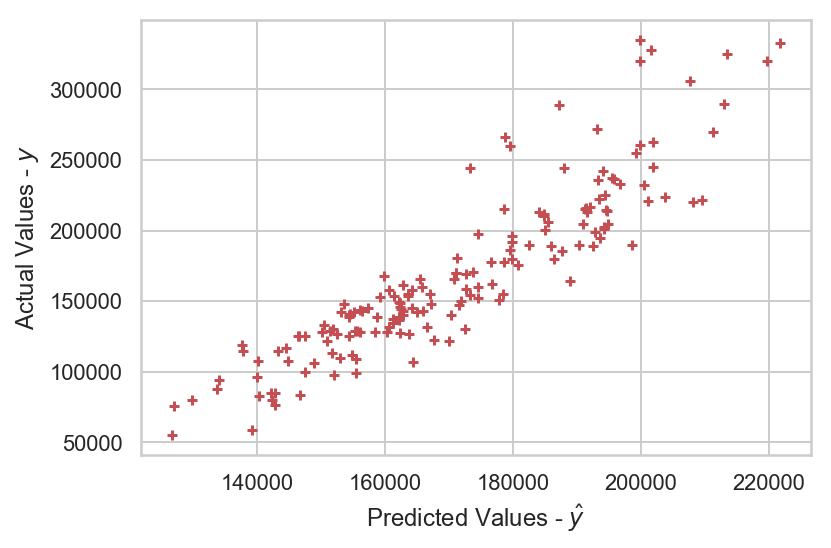

In [1640]:
# Plot the model with test dataset
# With test data set
Xs_test = ss.fit_transform(X_test)
predictions = ridgeregcv.predict(Xs_test)
print("RMSE for whole dataset:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('RidgeCV test score : {}'.format(ridgeregcv.score(Xs_test,y_test)))
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

#### <b>Using LassoCV for regularization</b>

In [1641]:
optimal_lasso = LassoCV(n_alphas=100, cv=10, verbose=1, random_state=42)
optimal_lasso.fit(Xs_train, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

629.974042433638


....................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


In [1642]:
lassoregcv = LassoCV(n_alphas=100, random_state=42, cv=10)
#yr_train = y_train.values.ravel()
lassoregcv.fit(Xs_train, y_train)
print('Best lasso alpha: {}'.format(lassoregcv.alpha_))

# predict method uses the best alpha value
y_pred = lassoregcv.predict(X_test)
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('LassoregCV train score : {}'.format(lassoregcv.score(Xs_train,y_train)))

Best lasso alpha: 629.974042433638
90616931.45051232
LassoregCV train score : 0.8482415833847475


RMSE for whole dataset: 21323.449584436446
LassoregCV test score : 0.8687752669809549


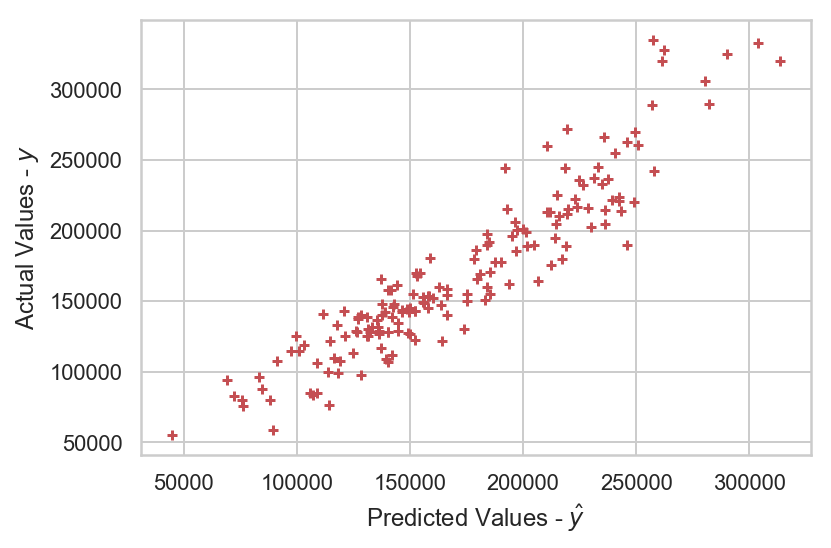

In [1643]:
# Plot the model with test dataset which are standardized during RidgeCV
# With test data set
predictions = lassoregcv.predict(Xs_test)
print("RMSE for whole dataset:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('LassoregCV test score : {}'.format(lassoregcv.score(Xs_test,y_test)))
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

In [1644]:
# examine the coefficients
#print("Coefficients : \n{}".format(list(zip(X_train.columns,lassoregcv.coef_))))
train_dataset[train_dataset.columns.difference(['SalePrice'])]
print("After applying Lasso for regularization, the following features are minimized to zero.\n{}" \
      .format([ x[0] for x in list(zip(train_dataset[train_dataset.columns.difference(['SalePrice'])].columns,lassoregcv.coef_)) if x[1]==0]))

After applying Lasso for regularization, the following features are minimized to zero.
['BsmtFinSF2', 'BsmtUnfSF', 'Condition1[T.PosA]', 'Condition1[T.RRAn]', 'Condition2[T.RRAn]', 'Condition2[T.RRNn]', 'Foundation[T.CBlock]', 'Foundation[T.Stone]', 'Functional[T.Min1]', 'Functional[T.Min2]', 'Functional[T.Mod]', 'GarageArea', 'GarageYrBlt', 'HalfBath', 'LandContour[T.HLS]', 'LandContour[T.Lvl]', 'LotConfig[T.Inside]', 'LotFrontage', 'LotShape[T.IR2]', 'MSZoning[T.FV]', 'MSZoning[T.RM]', 'Neighborhood[T.BrDale]', 'Neighborhood[T.CollgCr]', 'Neighborhood[T.IDOTRR]', 'Neighborhood[T.NPkVill]', 'Neighborhood[T.NWAmes]', 'Neighborhood[T.SWISU]', 'Neighborhood[T.SawyerW]', 'SaleCondition[T.Alloca]', 'SaleCondition[T.Partial]', 'SaleType[T.ConLD]', 'SaleType[T.ConLw]', 'SaleType[T.Oth]', 'SaleType[T.WD]', 'SecondFlrSF', 'TotRmsAbvGrd']


In [1645]:
print("After applying Lasso for regularization, the following features are left to use for model.\n{}" \
      .format([ x[0] for x in list(zip(train_dataset[train_dataset.columns.difference(['SalePrice'])].columns,lassoregcv.coef_)) if x[1]!=0]))

After applying Lasso for regularization, the following features are left to use for model.
['Alley[T.Pave]', 'BedroomAbvGr', 'BldgType[T.Duplex]', 'BldgType[T.TwnhsE]', 'BldgType[T.Twnhs]', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtHalfBath', 'Condition1[T.Feedr]', 'Condition1[T.Norm]', 'Condition1[T.PosN]', 'Condition1[T.RRAe]', 'Condition1[T.RRNn]', 'Condition2[T.Feedr]', 'Condition2[T.Norm]', 'Condition2[T.PosA]', 'Condition2[T.PosN]', 'EnclosedPorch', 'FirstFlrSF', 'Foundation[T.PConc]', 'Foundation[T.Slab]', 'FullBath', 'Functional[T.Maj2]', 'Functional[T.Typ]', 'GarageCars', 'GrLivArea', 'LandSlope[T.Mod]', 'LotArea', 'LotConfig[T.CulDSac]', 'LotConfig[T.FR2]', 'LotShape[T.Reg]', 'LowQualFinSF', 'MSSubClass', 'MSZoning[T.RL]', 'Neighborhood[T.BrkSide]', 'Neighborhood[T.ClearCr]', 'Neighborhood[T.Crawfor]', 'Neighborhood[T.Edwards]', 'Neighborhood[T.Gilbert]', 'Neighborhood[T.MeadowV]', 'Neighborhood[T.Mitchel]', 'Neighborhood[T.NAmes]', 'Neighborhood[T.NoRidge]', 'Neighborhood[T.NridgHt

#### <b>Using Elastic-Net for regularization</b>

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [1646]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [1647]:
# A: